In [98]:
# importing dependencies
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
from datetime import date, timedelta

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM

import matplotlib.pyplot as plt

In [99]:
today = date.today()

d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=5000)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

In [100]:
data = yf.download('AAPL', start=start_date, end=end_date, progress=False, auto_adjust=False)

# Drop multi-index level if it exists
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.droplevel(0)  

# Rename columns properly
data.columns = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]

print(data.head())  # Verify the structure

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2011-07-05  10.515605  12.479643  12.493929  12.232143  12.250000  355054000
2011-07-06  10.585723  12.562857  12.646429  12.382500  12.462500  444626000
2011-07-07  10.749433  12.757143  12.785714  12.642857  12.666786  399663600
2011-07-08  10.824969  12.846786  12.857143  12.578571  12.619286  489633200
2011-07-11  10.653131  12.642857  12.848929  12.600714  12.726429  442674400


In [101]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-07-05,10.515605,12.479643,12.493929,12.232143,12.250000,355054000
2011-07-06,10.585723,12.562857,12.646429,12.382500,12.462500,444626000
2011-07-07,10.749433,12.757143,12.785714,12.642857,12.666786,399663600
2011-07-08,10.824969,12.846786,12.857143,12.578571,12.619286,489633200
2011-07-11,10.653131,12.642857,12.848929,12.600714,12.726429,442674400


In [102]:
data = data.reset_index()

In [103]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3437,2025-03-05,235.740005,235.740005,236.550003,229.229996,235.419998,47227600
3438,2025-03-06,235.330002,235.330002,237.860001,233.160004,234.440002,45170400
3439,2025-03-07,239.070007,239.070007,241.369995,234.759995,235.110001,46273600
3440,2025-03-10,227.479996,227.479996,236.160004,224.220001,235.539993,72071200
3441,2025-03-11,220.839996,220.839996,225.839996,217.449997,223.809998,76087700


In [104]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

A candlestick chart gives a clear picture of the increase and decrease in stock prices, so let’s visualize a candlestick chart of the data before moving further

In [105]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(
    x=data["Date"],
    open=data["Open"],
    high=data["High"],
    low=data["Low"],
    close=data["Close"]
)])

fig.update_layout(
    title="Apple Stock Price Analysis",
    xaxis_rangeslider_visible=False
)

fig.show()

In [106]:
correlation = data.corr()
print(correlation["Close"].sort_values(ascending=False))

Close        1.000000
High         0.999896
Adj Close    0.999889
Open         0.999871
Low          0.999863
Date         0.913607
Volume      -0.527977
Name: Close, dtype: float64


LSTM Model:

In [ ]:
x = data[['Open', 'High', 'Low', 'Volume']]
y = data['Close']

x = x.to_numpy()
y = y.to_numpy()
y = y.reshape(-1,1)

In [107]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[['Open', 'High', 'Low', 'Volume', 'Close']])

# Create the X (features) and y (target) for training
x = data_scaled[:, :-1]  # All features except 'Close'
y = data_scaled[:, -1]   # 'Close' as target

x = x.reshape((x.shape[0], x.shape[1], 1))  # Reshaping for LSTM
y = y.reshape(-1, 1)

In [108]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

In [109]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [110]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 4, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,619 (459.45 KB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

In [111]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [112]:
history = model.fit(x_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0024
Epoch 2/10
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 3.2696e-04
Epoch 3/10
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 1.2126e-04
Epoch 4/10
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 1.2878e-04
Epoch 5/10
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 8.4580e-05
Epoch 6/10
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 1.3926e-04
Epoch 7/10
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 9.8998e-05
Epoch 8/10
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 4.7262e-05
Epoch 9/10
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 1.1208e-04
Epoch 10/10
2753/2753 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 7.7502e-05


In [114]:
#evaluate the model
loss = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0027e-04 
Test Loss: 0.00019593896286096424


In [115]:
predictions = model.predict(x_test)

# Invert the scaling to get the actual values
predictions_actual = scaler.inverse_transform(np.hstack((x_test.reshape(-1, x_test.shape[1]), predictions)))
y_test_actual = scaler.inverse_transform(np.hstack((x_test.reshape(-1, x_test.shape[1]), y_test)))

# Extract the 'Close' column
predicted_prices = predictions_actual[:, -1]
true_prices = y_test_actual[:, -1]

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


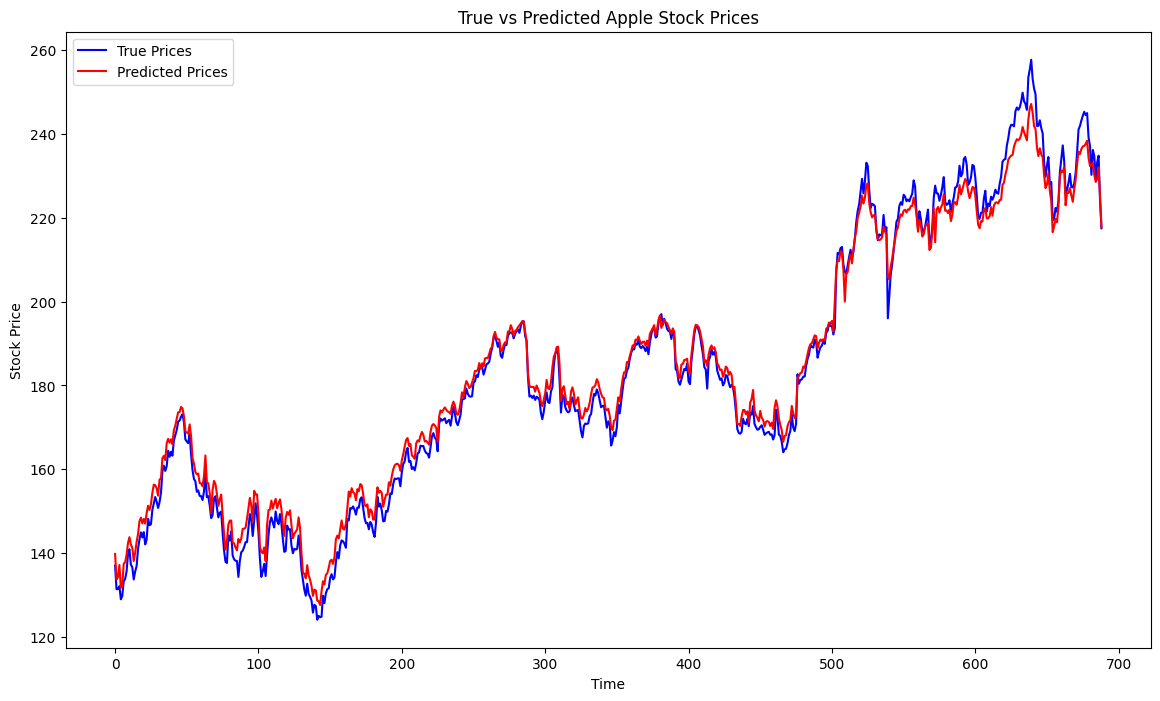

In [116]:
plt.figure(figsize=(14,8))
plt.plot(true_prices, label='True Prices', color='blue')
plt.plot(predicted_prices, label='Predicted Prices', color='red')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('True vs Predicted Apple Stock Prices')
plt.legend()
plt.show()

Forecasting:

In [117]:
last_data = data_scaled[-1, :-1].reshape(1, -1, 1)  # Last data point as input
forecast = model.predict(last_data)

# Invert scaling to get the actual price
forecast_actual = scaler.inverse_transform(np.hstack((last_data.reshape(-1, last_data.shape[1]), forecast)))
predicted_future_price = forecast_actual[:, -1]

print(f"Predicted Future Price: {predicted_future_price}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Future Price: [217.69935614]


In [119]:
model.save("Apple_Stock_Price.h5")